In [50]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf 
import sklearn
import seaborn as sn
from tensorflow import keras
from keras import layers
from utils import *
from models import * 
from sklearn.linear_model import LogisticRegression as LogRes
from sklearn.metrics import classification_report as report
from sklearn.metrics import precision_score as precision 
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1


print("numpy version: \t\t", np.__version__)
print("pandas version: \t", pd.__version__)
print("matplotlib version: \t", matplotlib.__version__)
print("tensorflow version: \t", tf.__version__)
print("scikit-learn version: \t", sklearn.__version__)
print("seaborn version: \t", sn.__version__)

numpy version: 		 1.19.2
pandas version: 	 1.2.3
matplotlib version: 	 3.3.4
tensorflow version: 	 2.3.0
scikit-learn version: 	 0.24.1
seaborn version: 	 0.11.1


In [2]:
x_train, y_train = load_data("../data/Simulated_Data_Train.csv")
x_val, y_val = load_data("../data/Simulated_Data_Validation.csv")
x_test, y_test = load_data("../data/Simulated_Data_Test.csv")

In [6]:
lr = log_reg(x_train, y_train)
yprob = lr.predict(x_test)
yhat = decide(yprob, 0.5)
print(report(y_test, lr.model.predict(x_test)))


              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4599
         1.0       0.72      0.20      0.31       401

    accuracy                           0.93      5000
   macro avg       0.83      0.60      0.64      5000
weighted avg       0.92      0.93      0.91      5000



In [19]:
credit_data = load_data("../data/Simulated_Data_Test.csv", as_df = True)

coef_dict = {}
for var, coef in zip(credit_data.columns, lr.model.coef_[0]): 
    coef_dict[var] = coef
    
coef_frame = pd.DataFrame.from_dict(coef_dict, 'index', columns = ["coefficient"])
coef_frame.to_latex("../report/coef.tex")

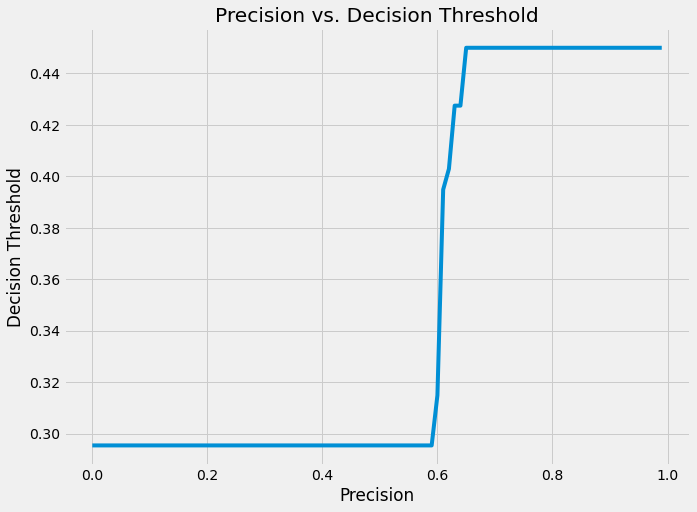

In [34]:
def tune_threshold(y, y_prob, eta = 0.1, plev = 0.5, max_iter = 100, output = True):
    """
    Tunes the threshold of the decision rule to improve accuracy.
    
    Keyword Arguments: 
    y - theground truth
    y_prob - the model predictions
    eta - learning rate 
    plev - the level of precision we are trying to maintain
    """
    threshold = 0.5
    yhat = decide(y_prob, threshold)
    p = precision(y, yhat)
    r = recall(y, yhat)
    initial_loss = directional_loss(y, yhat)
    if output: 
        print(f"Precision = {p}, Recall = {r}, Threshold = {threshold}")
    
    for i in range(1, max_iter): 
        threshold -= eta/i*threshold
        yhat = decide(y_prob, threshold)
        
        
        p = precision(y, yhat)
        r = recall(y, yhat)
        
        if output: 
            print(f"Precision = {p}, Recall = {r}, Threshold = {threshold}")
        
        if (p <= plev): 
            return threshold
            
    return threshold

y_prob = lr.predict(x_val)

plevels = [_ for _ in np.arange(0, 1, 0.01)]
thresholds = []

for p in plevels: 
    thresholds.append(tune_threshold(y_val, y_prob, plev = p, output = False))
    
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [10, 7.5]

plt.plot(plevels, thresholds)
plt.xlabel("Precision")
plt.ylabel("Decision Threshold")
plt.title("Precision vs. Decision Threshold")
plt.savefig("precisionvsthreshold.png")

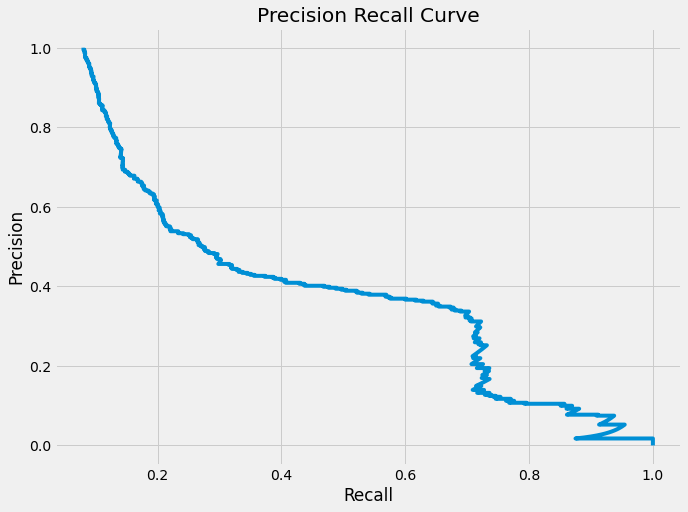

In [35]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test ,lr.predict(x_test))
plt.title("Precision Recall Curve")
plt.plot(precision_lr, recall_lr)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("pr_curve_lr.png")

In [44]:
tune_threshold(y_val, y_prob, plev = 0.5, eta = 0.2, max_iter = 1000, output = False)
print(report(y_test, decide(lr.predict(x_test), 0.1514)))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      4599
         1.0       0.61      0.37      0.46       401

    accuracy                           0.93      5000
   macro avg       0.78      0.67      0.71      5000
weighted avg       0.92      0.93      0.92      5000



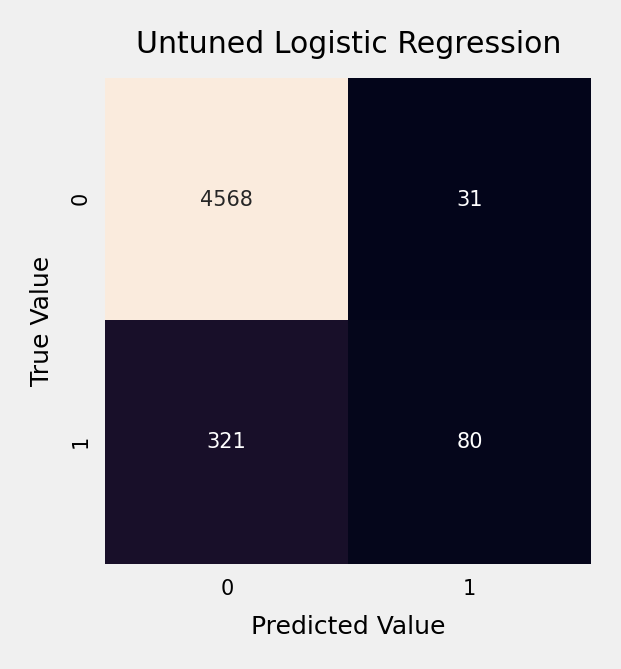

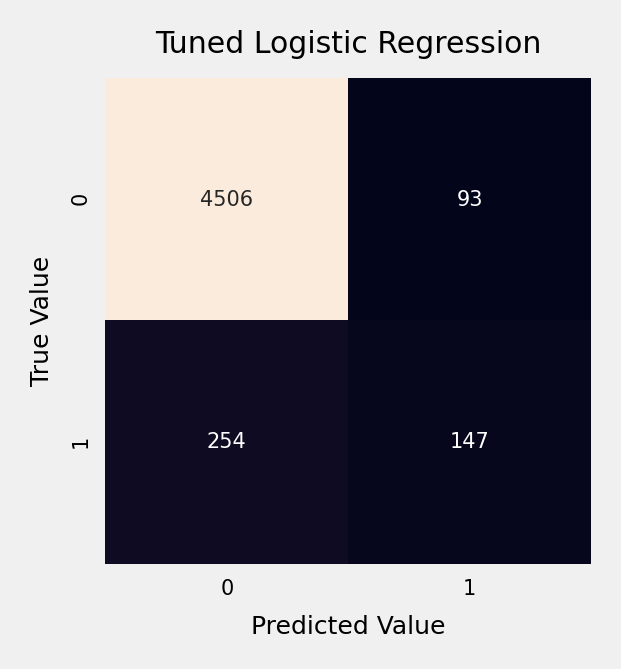

In [51]:
def plot_conf_mat(title, conf_mat, save = None): 
    plt.rcParams["figure.figsize"] = [2, 2]
    plt.rcParams["font.size"] = 5
    plt.rcParams["figure.dpi"] = 300
    sn.heatmap(conf_mat, 
                square = True,
                fmt = 'g',
                annot = True,
                cbar = False)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title(title)
    if save: 
        plt.savefig(save)
        plt.show()
    else: 
        plt.show()
        
plot_conf_mat("Untuned Logistic Regression", 
              confusion_matrix(y_test, decide(lr.predict(x_test), 0.5)), 
              "untuned_log_reg.png")

plot_conf_mat("Tuned Logistic Regression", 
              confusion_matrix(y_test, decide(lr.predict(x_test), 0.1514)), 
              "tuned_log_reg.png")
        